<a href="https://colab.research.google.com/github/vivekvardhannali/clustering_customers_of_a_supermarket/blob/main/file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# URL of the dataset
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

df = pd.read_excel(data_url)


In [2]:
#eda
print(df.isnull().sum())
#there are empty cells in the dataset we have to fill them

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [3]:

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Calculating the total bill for each transaction.
df['Total_Bill'] = df['Quantity'] * df['UnitPrice']

print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Total_Bill          0
dtype: int64


In [4]:
customer_df = df.groupby('CustomerID').agg(
    Total_Bill_Size=('Total_Bill', 'sum'),
    First_Purchase=('InvoiceDate', 'min'),
    Last_Purchase=('InvoiceDate', 'max'),
    Most_Common_Location=('Country', lambda x: x.mode()[0]),
    Top_Item=('StockCode', lambda x: x.value_counts().idxmax())
)
customer_df['Purchase_Interval_Days'] = (customer_df['Last_Purchase'] - customer_df['First_Purchase']).dt.days

from sklearn.impute import SimpleImputer

# Drop date columns
customer_df = customer_df.drop(columns=['First_Purchase', 'Last_Purchase'])

# Handle missing values
# We'll use SimpleImputer for numerical and categorical separately
# Impute numeric columns
num_cols = ['Total_Bill_Size', 'Purchase_Interval_Days']
num_imputer = SimpleImputer(strategy='mean')
customer_df[num_cols] = num_imputer.fit_transform(customer_df[num_cols])

# Impute categorical columns
cat_cols = ['Most_Common_Location', 'Top_Item']
cat_imputer = SimpleImputer(strategy='most_frequent')
customer_df[cat_cols] = cat_imputer.fit_transform(customer_df[cat_cols])
#encoding
customer_df_encoded = pd.get_dummies(customer_df, columns=cat_cols)
#standardizing
scaler = StandardScaler()
customer_df_encoded[num_cols] = scaler.fit_transform(customer_df_encoded[num_cols])

#Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
customer_df_encoded['Cluster'] = kmeans.fit_predict(customer_df_encoded)

customer_df['Cluster'] = customer_df_encoded['Cluster']
print(customer_df_encoded)

            Total_Bill_Size  Purchase_Interval_Days  \
CustomerID                                            
12346.0           -0.231001               -1.004183   
12347.0            0.293432                1.743685   
12348.0           -0.012316                1.118827   
12349.0           -0.017146               -1.004183   
12350.0           -0.190312               -1.004183   
...                     ...                     ...   
18280.0           -0.209026               -1.004183   
18281.0           -0.221167               -1.004183   
18282.0           -0.209513               -0.115831   
18283.0            0.023900                1.502776   
18287.0           -0.007444                0.185305   

            Most_Common_Location_Australia  Most_Common_Location_Austria  \
CustomerID                                                                 
12346.0                              False                         False   
12347.0                              False              

In [ ]:
def summarize_cluster_info(clustered_df):
    for i in range(kmeans.n_clusters):
        cluster_data = clustered_df[clustered_df['Cluster'] == i]
        print(f"\nCluster {i} Summary:")

        # Customer count in each cluster
        customer_count = len(cluster_data)
        print(f"Number of Customers in the cluster: {customer_count}")

        # Average spend in each cluster
        avg_spend = cluster_data['Total_Bill_Size'].mean()
        print(f"Average Spend: ${avg_spend:.2f}")

        # Top 3 Locations with counts
        top_locations = cluster_data['Most_Common_Location'].value_counts().head(3)
        print("Top 3 Locations:")
        for location, count in top_locations.items():
            print(f"{location}: {count} customers")

        # Top 3 Items with counts
        top_items = cluster_data['Top_Item'].value_counts().head(3)
        print("Top 3 Item Codes:")
        for item, count in top_items.items():
            print(f"{item}: {count} times purchased")

# Call the function to display the summary
summarize_cluster_info(customer_df)


Cluster 0 Summary:
Number of Customers in the cluster: 1118
Average Spend: $3532.47
Top 3 Locations:
United Kingdom: 1014 customers
Germany: 30 customers
France: 24 customers
Top 3 Item Codes:
POST: 58 times purchased
85123A: 43 times purchased
85099B: 35 times purchased

Cluster 1 Summary:
Number of Customers in the cluster: 2179
Average Spend: $510.71
Top 3 Locations:
United Kingdom: 1961 customers
Germany: 44 customers
France: 42 customers
Top 3 Item Codes:
22423: 38 times purchased
POST: 24 times purchased
85123A: 23 times purchased

Cluster 2 Summary:
Number of Customers in the cluster: 3
Average Spend: $241136.56
Top 3 Locations:
United Kingdom: 2 customers
Netherlands: 1 customers
Top 3 Item Codes:
22629: 1 times purchased
22470: 1 times purchased
22189: 1 times purchased

Cluster 3 Summary:
Number of Customers in the cluster: 16
Average Spend: $69480.85
Top 3 Locations:
United Kingdom: 13 customers
EIRE: 2 customers
Australia: 1 customers
Top 3 Item Codes:
22197: 3 times purch

In [ ]:
from sklearn.cluster import DBSCAN
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

customer_df=customer_df.drop(columns=[ 'Cluster'])
customer_df_encoded=customer_df_encoded.drop(columns=[ 'Cluster'])
clusters = dbscan.fit_predict(customer_df_encoded)

noise = customer_df_encoded[customer_df_encoded['Cluster'] == -1]
print(f"Noise points count: {len(noise)}")


KeyError: 'Cluster'

In [ ]:
customer_df['Cluster'] = clusters
# Summary of results
def summarize_clusters2(df):
    grouped = df.groupby('Cluster')
    for key, group in grouped:
        if key == -1:
            continue  # Skip the noise points for detailed summary
        print(f"\nCluster {key} Summary:")
        print(f"Number of Customers: {len(group)}")
        avg_bill = group['Total_Bill_Size'].mean()
        avg_interval = group['Purchase_Interval_Days'].mean()
        print(f"Average Total Bill: {avg_bill:.2f}")
        print(f"Average Purchase Interval: {avg_interval:.2f}")

summarize_clusters2(customer_df)


Cluster 0 Summary:
Number of Customers: 9
Average Total Bill: 1662.08
Average Purchase Interval: 161.56

Cluster 1 Summary:
Number of Customers: 38
Average Total Bill: 2712.74
Average Purchase Interval: 218.32

Cluster 2 Summary:
Number of Customers: 22
Average Total Bill: 4059.27
Average Purchase Interval: 291.64

Cluster 3 Summary:
Number of Customers: 6
Average Total Bill: 1294.54
Average Purchase Interval: 242.00

Cluster 4 Summary:
Number of Customers: 5
Average Total Bill: 523.24
Average Purchase Interval: 26.40

Cluster 5 Summary:
Number of Customers: 15
Average Total Bill: 507.64
Average Purchase Interval: 9.47

Cluster 6 Summary:
Number of Customers: 44
Average Total Bill: 1235.68
Average Purchase Interval: 126.09

Cluster 7 Summary:
Number of Customers: 90
Average Total Bill: 1747.54
Average Purchase Interval: 208.94

Cluster 8 Summary:
Number of Customers: 5
Average Total Bill: 424.72
Average Purchase Interval: 6.40

Cluster 9 Summary:
Number of Customers: 13
Average Total 

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

df = pd.read_excel(data_url)
print(df.isnull().sum())
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Total_Bill'] = df['Quantity'] * df['UnitPrice']

customer_df = df.groupby('CustomerID').agg(
    Total_Bill_Size=('Total_Bill', 'sum'),
    First_Purchase=('InvoiceDate', 'min'),
    Last_Purchase=('InvoiceDate', 'max'),
    Most_Common_Location=('Country', lambda x: x.mode()[0]),
    Top_Item=('StockCode', lambda x: x.value_counts().idxmax())
)
customer_df['Purchase_Interval_Days'] = (customer_df['Last_Purchase'] - customer_df['First_Purchase']).dt.days
#print(customer_df[customer_df['Total_Bill_Size'] < 0])

from sklearn.impute import SimpleImputer

customer_df = customer_df.drop(columns=['First_Purchase', 'Last_Purchase'])

num_cols = ['Total_Bill_Size', 'Purchase_Interval_Days']
num_imputer = SimpleImputer(strategy='mean')
customer_df[num_cols] = num_imputer.fit_transform(customer_df[num_cols])

cat_cols = ['Most_Common_Location', 'Top_Item']
cat_imputer = SimpleImputer(strategy='most_frequent')
customer_df[cat_cols] = cat_imputer.fit_transform(customer_df[cat_cols])

customer_df_encoded = pd.get_dummies(customer_df, columns=cat_cols)

scaler = StandardScaler()
customer_df_encoded[num_cols] = scaler.fit_transform(customer_df_encoded[num_cols])

cluster_count=5
kmeans = KMeans(n_clusters=cluster_count, random_state=42, n_init=10)
customer_df_encoded['Cluster'] = kmeans.fit_predict(customer_df_encoded)

customer_df['Cluster'] = customer_df_encoded['Cluster']
customer_df['Total_Bill_Size_Original'] = customer_df['Total_Bill_Size']

def summarize_cluster_info(clustered_df):
    for i in range(kmeans.n_clusters):
        cluster_data = clustered_df[clustered_df['Cluster'] == i]
        print(f"\nCluster {i} Summary:")
        customer_count = len(cluster_data)
        print(f"Number of Customers in the cluster: {customer_count}")
        avg_spend = cluster_data['Total_Bill_Size_Original'].mean()
        print(f"Average Spend: ${avg_spend:.2f}")
        top_locations = cluster_data['Most_Common_Location'].value_counts().head(3)
        print("Top 3 Locations:")
        for location, count in top_locations.items():
            print(f"{location}: {count} customers")
        top_items = cluster_data['Top_Item'].value_counts().head(3)
        print("Top 3 Item Codes:")
        for item, count in top_items.items():
            print(f"{item}: {count} times purchased")

summarize_cluster_info(customer_df)

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)

customer_df=customer_df.drop(columns=['Cluster'])
customer_df_encoded=customer_df_encoded.drop(columns=['Cluster'])
clusters = dbscan.fit_predict(customer_df_encoded)
customer_df['Cluster'] = clusters

noise = customer_df[customer_df['Cluster'] == -1]
print(f"Noise points count: {len(noise)}")

print("USING DBSCAN TO FORM THE CLUSTERS\n")
def summarize_clusters2(df):
    grouped = df.groupby('Cluster')
    for key, group in grouped:
        if key == -1:
            continue
        print(f"\nCluster {key} Summary:")
        print(f"Number of Customers: {len(group)}")
        avg_bill = group['Total_Bill_Size_Original'].mean()
        avg_interval = group['Purchase_Interval_Days'].mean()
        print(f"Average Total Bill: {avg_bill:.2f}")
        print(f"Average Purchase Interval: {avg_interval:.2f}")

summarize_clusters2(customer_df)


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
            Total_Bill_Size      First_Purchase       Last_Purchase  \
CustomerID                                                            
12503.0       -1.126000e+03 2011-01-06 11:51:00 2011-01-06 11:51:00   
12505.0       -4.500000e+00 2011-02-11 13:39:00 2011-02-11 13:39:00   
12605.0       -7.500000e+00 2010-12-09 15:41:00 2010-12-09 15:41:00   
12666.0       -2.274400e+02 2010-12-15 14:42:00 2010-12-15 14:42:00   
12870.0       -1.490000e+01 2010-12-08 14:27:00 2010-12-08 14:27:00   
12943.0       -3.750000e+00 2011-02-11 15:13:00 2011-02-11 15:13:00   
13154.0       -6.118600e+02 2011-07-18 15:21:00 2011-07-18 15:21:00   
13672.0       -7.146000e+01 2011-01-10 12:02:00 2011-02-11 13:55:00   
13693.0       -3.200000e+01 2011-01-18 15:21:00 2011-01-18 15:23:00   
13829.0       -1.020000e+02 20

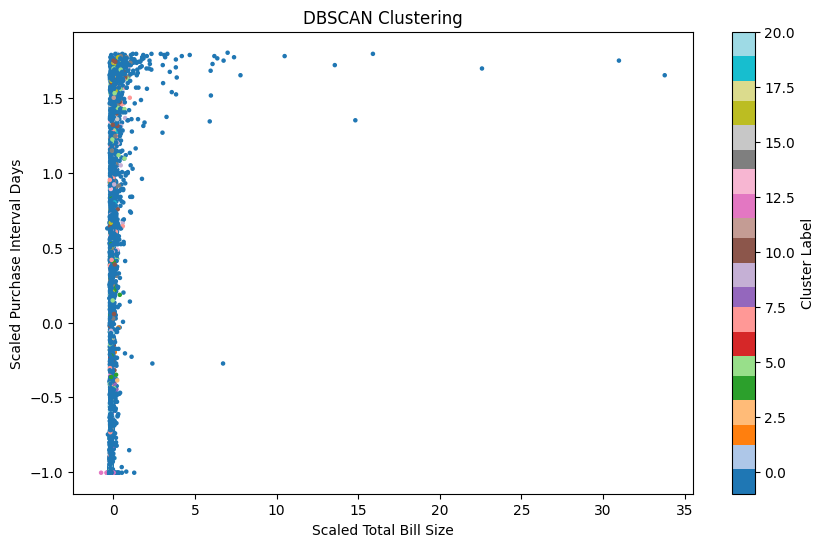

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a color map for up to 94 unique cluster labels
colors = plt.cm.tab20(np.linspace(0, 1, 94))  # 94 distinct colors from tab20
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 6))
plt.scatter(
    customer_df_encoded['Total_Bill_Size'],
    customer_df_encoded['Purchase_Interval_Days'],
    c=clusters, cmap=cmap, s=5
)

plt.title('DBSCAN Clustering')
plt.xlabel('Scaled Total Bill Size')
plt.ylabel('Scaled Purchase Interval Days')
plt.colorbar(label='Cluster Label')
plt.show()
